# Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from PIL import Image, ImageDraw
import numpy as np
import zlib
import base64
import io
import json
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
import glob
import re
import gc
import cv2
from sklearn.metrics import confusion_matrix
import os
import pickle
from torch import optim
from torch.nn.utils import clip_grad_norm_

# Loading the dataset

In [ ]:
image_dir = '/content/drive/MyDrive/coffee-datasets/segmentation/images/train/'
mask_dir =  '/content/drive/MyDrive/coffee-datasets/segmentation/annotations/train/'


image_files = glob.glob(os.path.join(image_dir, '*.jpg'))
mask_files = glob.glob(os.path.join(mask_dir, '*_mask.png'))


def extract_prefix(filename, mask=False):
    if mask:
        return re.match(r"(\d+)_mask\.png", os.path.basename(filename)).group(1)
    else:
        return re.match(r"(\d+)\.jpg", os.path.basename(filename)).group(1)


image_dict = {extract_prefix(f): f for f in image_files}
mask_dict = {extract_prefix(f, mask=True): f for f in mask_files}


sorted_prefixes = sorted(image_dict.keys())
paired_files = [(image_dict[prefix], mask_dict[prefix]) for prefix in sorted_prefixes]


train_images = []
train_masks = []

for image_path, mask_path in paired_files:
    image = Image.open(image_path)
    mask = Image.open(mask_path)
    train_images.append(image)
    train_masks.append(mask)

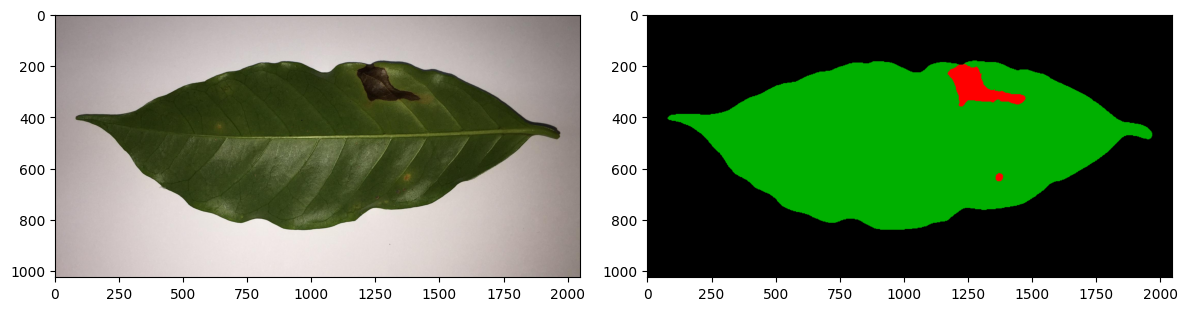

In [ ]:
i = 5

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(train_images[i])
axes[1].imshow(train_masks[i])

plt.tight_layout()
plt.show()

In [ ]:
mapping = {
    (0, 0, 0): 0, # Background
    (0, 176, 0): 1, # Leaf
    (255, 0, 0): 2 # symptom
}

## Resizing images and masks

In [ ]:
new_size = (1024, 512)

def resize_image_and_mask(image, mask, size):

    resized_image = image.resize(size, Image.ANTIALIAS)
    resized_mask = mask.resize(size, Image.NEAREST)
    return resized_image, resized_mask


resized_images = []
resized_masks = []

for img, msk in zip(train_images, train_masks):
    resized_img, resized_msk = resize_image_and_mask(img, msk, new_size)
    resized_images.append(resized_img)
    resized_masks.append(resized_msk)

del train_images
del train_masks

<ipython-input-6-2b34daca7096>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize(size, Image.ANTIALIAS)


In [ ]:
gc.collect()

75

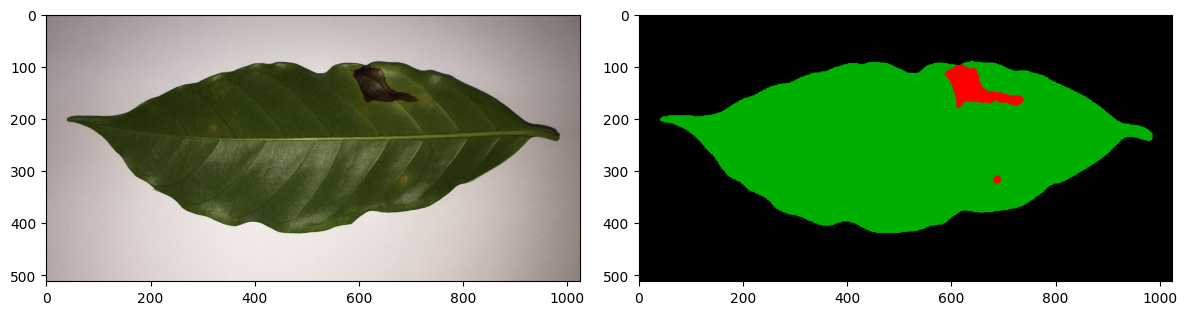

In [ ]:
i = 5

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(resized_images[i])
axes[1].imshow(resized_masks[i])

plt.tight_layout()
plt.show()

In [ ]:
resized_images = [np.array(img) for img in resized_images]
resized_masks = [np.array(mask) for mask in resized_masks]

## Converting the masks into single channel images for training

In [ ]:
def convert_image_to_single_channel(image_array):

    single_channel = np.zeros((image_array.shape[0], image_array.shape[1]), dtype=np.uint8)

    for rgb, class_index in mapping.items():
        mask = np.all(image_array == rgb, axis=-1)
        single_channel[mask] = class_index

    return single_channel

def process_images(images):
    processed_images = []
    for image_array in images:
        single_channel_image = convert_image_to_single_channel(image_array)
        processed_images.append(single_channel_image)
    return processed_images

In [ ]:
train_masks_one_ch = process_images(resized_masks)

# Data Preprocessing


In [ ]:
def histogram_equalization(image):
    img_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    return img_output

high_contrast_img = []
for img in resized_images:
  high_contrast_img.append(histogram_equalization(img))

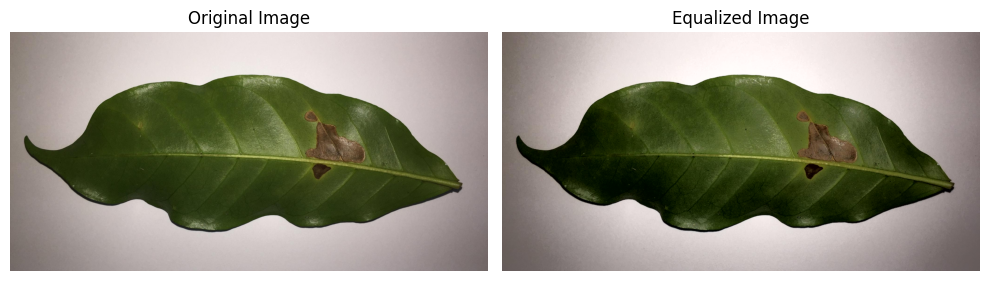

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(resized_images[1])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(high_contrast_img[1])
plt.title('Equalized Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
def calculate_mean_std(image_list, batch_size=64):
    mean = np.zeros(3)
    std = np.zeros(3)
    total_images_count = 0

    for i in range(0, len(image_list), batch_size):
        batch_images = np.stack(image_list[i:i+batch_size], axis=0)

        # Calculate mean and std for the current batch
        batch_mean = np.mean(batch_images, axis=(0, 1, 2))
        batch_std = np.std(batch_images, axis=(0, 1, 2))

        # Update the overall mean and std
        batch_image_count = batch_images.shape[0]
        total_images_count += batch_image_count

        mean = mean + batch_mean * batch_image_count
        std = std + batch_std * batch_image_count

    mean /= total_images_count
    std /= total_images_count

    return mean, std

In [ ]:
mean, std = calculate_mean_std(high_contrast_img)

In [ ]:
full_dataset = list(zip(high_contrast_img, train_masks_one_ch))

# Test and Validation Sets Creation

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, target = self.dataset[idx]

        target = torch.tensor(target, dtype=torch.long)
        target = target.clone().detach()

        return image, target


transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Normalize(mean=mean, std=std)
])


full_dataset = CustomDataset(full_dataset, transform=transform)

total_size = len(full_dataset)
train_size = int(0.7 * total_size)
validation_size = int(0.1 * total_size)
test_size = total_size - train_size - validation_size

generator = torch.Generator().manual_seed(42)
train, validation, test = torch.utils.data.random_split(full_dataset, [train_size, validation_size, test_size], generator=generator)

batch_size_train = 4
batch_size_val = 4
batch_size_test = 2

train_loader = DataLoader(train, batch_size=batch_size_train, shuffle=True, num_workers=2)
validation_loader = DataLoader(validation, batch_size=batch_size_val, shuffle=False, num_workers=2)
test_loader = DataLoader(test, batch_size=batch_size_test, shuffle=False, num_workers=2)

## DeepLabV3

In [ ]:
def initialize_weights(model):
    for module in model.modules():
      if isinstance(module, nn.Conv2d):
          nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
          if module.bias is not None:
              nn.init.constant_(module.bias, 0)
      elif isinstance(module, nn.BatchNorm2d):
          nn.init.constant_(module.weight, 1)
          nn.init.constant_(module.bias, 0)
      elif isinstance(module, nn.Linear):
          nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
          nn.init.constant_(module.bias, 0)

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from typing import List

class DeeplabV3(nn.Module):

    def __init__(self, backbone: nn.Module, classifier: nn.Module) -> None:
        super().__init__()
        self.backbone = backbone
        self.classifier = classifier

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        input_shape = x.shape[2:]

        x = self.backbone(x)
        x = self.classifier(x)
        x = F.interpolate(x, size=input_shape, mode="bilinear", align_corners=False)
        return x


class DeepLabHead(nn.Sequential):

    def __init__(self, in_channels: int, num_classes: int) -> None:
        super().__init__(
            ASPP(in_channels, [12, 24, 36]),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, 1),
        )


class ASPPConv(nn.Sequential):

    def __init__(self, in_channels: int, out_channels: int, dilation: int) -> None:
        modules = [
            nn.Conv2d(in_channels, out_channels, 3, padding=dilation, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        ]
        super().__init__(*modules)


class ASPPPooling(nn.Sequential):

    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        size = list(x.shape[2:])
        for mod in self:
            x = mod(x)
        return F.interpolate(x, size=size, mode="bilinear", align_corners=False)


class ASPP(nn.Module):

    def __init__(self, in_channels: int, atrous_rates: List[int], out_channels: int = 256) -> None:
        super().__init__()
        modules = []
        modules.append(
            nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, bias=False), nn.BatchNorm2d(out_channels), nn.ReLU())
        )

        rates = tuple(atrous_rates)
        for rate in rates:
            modules.append(ASPPConv(in_channels, out_channels, rate))

        modules.append(ASPPPooling(in_channels, out_channels))

        self.convs = nn.ModuleList(modules)

        self.project = nn.Sequential(
            nn.Conv2d(len(self.convs) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _res = []
        for conv in self.convs:
            _res.append(conv(x))
        res = torch.cat(_res, dim=1)
        return self.project(res)

In [ ]:
resnet = resnet50(weights= ResNet50_Weights.DEFAULT)
backbone = nn.Sequential(*list(resnet.children())[:-2])  # Remove last two layers (avgpool and fc)

in_channels = 2048

# Training

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = None

    def __call__(self, val_loss, model, optimizer, epoch, save_path):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, epoch, save_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, optimizer, epoch, save_path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, optimizer, epoch, save_path):
        '''Saves model when validation loss decreases.'''
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
            }, os.path.join(save_path, 'checkpoint.pth'))
            print(f'Saving model with validation loss {val_loss:.4f}')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

num_classes = 3

learning_rate = 0.0001

early_stopping = EarlyStopping(patience=15, delta=0.05)

initialize_weights(model)

In [ ]:
model = DeeplabV3(backbone=backbone, classifier=DeepLabHead(in_channels, num_classes))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

save_path = '/content/drive/My Drive/checkpoints_ADAM_DL'
os.makedirs(save_path, exist_ok=True)

loss_path = '/content/drive/My Drive/loss_ADAM_DL'
os.makedirs(loss_path, exist_ok=True)

checkpoint_path = '/content/drive/My Drive/checkpoints_ADAM_/model_epoch_24.pth'

# Load the checkpoint if available
if False: #os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 0
    print("No checkpoint found, starting training from scratch")

num_epochs = 70 - start_epoch

train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, targets in train_loader:

        images, targets = images.to(device), targets.to(device)
        images = images.permute(0, 3, 1, 2)
        images = images.float()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    train_loss_list.append(train_loss)

    if epoch > 15:
      scheduler.step(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, targets in validation_loader:
            images, targets = images.to(device), targets.to(device)

            images = images.permute(0, 3, 1, 2)
            images = images.float()

            outputs = model(images)
            loss = criterion(outputs.to(device), targets.to(device))

            val_loss += loss.item() * images.size(0)

    val_loss /= len(validation_loader.dataset)
    val_loss_list.append(val_loss)

    if epoch > 15:
      scheduler.step(val_loss)

    print(f'Epoch {start_epoch + epoch+1}/{start_epoch + num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    early_stopping(val_loss, model, optimizer, epoch+1, save_path)

    if early_stopping.early_stop:
        print("Early stopping")
        break

    if (epoch + start_epoch + 1) % 3 == 0:
        checkpoint_path = os.path.join(save_path, f'model_epoch_{epoch + start_epoch + 1}.pth')
        torch.save({
            'epoch': epoch + start_epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, checkpoint_path)
        print(f'Model saved to {checkpoint_path}')

        with open(os.path.join(loss_path, 'train_loss_list.pkl'), 'wb') as f:
            pickle.dump(train_loss_list, f)
        with open(os.path.join(loss_path, 'val_loss_list.pkl'), 'wb') as f:
            pickle.dump(val_loss_list, f)
        print(f'Train and validation losses saved to {loss_path}')


# Test the model
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, targets in test_loader:
        images, targets = images.to(device), targets.to(device)

        images = images.permute(0, 3, 1, 2)
        images = images.float()

        outputs = model(images)
        loss = criterion(outputs, targets)

        test_loss += loss.item() * images.size(0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

No checkpoint found, starting training from scratch


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/70, Train Loss: 1.7604, Validation Loss: 0.2493
Saving model with validation loss 0.2493
Saving model with validation loss 0.1431
Epoch 3/70, Train Loss: 0.1161, Validation Loss: 0.0749
Saving model with validation loss 0.0749
Model saved to /content/drive/My Drive/checkpoints_ADAM_DL/model_epoch_3.pth
Train and validation losses saved to /content/drive/My Drive/loss_ADAM_DL
Epoch 4/70, Train Loss: 0.0758, Validation Loss: 0.0837
Epoch 5/70, Train Loss: 0.0635, Validation Loss: 0.0443
Epoch 6/70, Train Loss: 0.0494, Validation Loss: 0.0381
Model saved to /content/drive/My Drive/checkpoints_ADAM_DL/model_epoch_6.pth
Train and validation losses saved to /content/drive/My Drive/loss_ADAM_DL
Epoch 7/70, Train Loss: 0.0443, Validation Loss: 0.0356
Epoch 8/70, Train Loss: 0.0412, Validation Loss: 0.0360
Epoch 9/70, Train Loss: 0.0358, Validation Loss: 0.0358
Model saved to /content/drive/My Drive/checkpoints_ADAM_DL/model_epoch_9.pth
Train and validation losses saved to /content/driv

In [ ]:
checkpoint_path = '/content/drive/My Drive/checkpoints_ADAM_DL/model_epoch_30.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Metrics

In [ ]:
def calculate_iou(pred, target, num_classes):
    pred = pred.view(-1)
    target = target.view(-1)
    ious = np.zeros(num_classes)
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().item()
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection
        if union > 0:
            ious[cls] = float(intersection) / float(max(union, 1))
    return ious

def calculate_dice(pred, target, num_classes):
    pred = pred.view(-1)
    target = target.view(-1)
    dices = np.zeros(num_classes)
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().item()
        dice = (2. * intersection) / (pred_inds.long().sum().item() + target_inds.long().sum().item() + 1e-10)
        dices[cls] = dice
    return dices

def calculate_pixel_accuracy(pred, target, num_classes):
    pred = pred.view(-1)
    target = target.view(-1)
    accuracies = np.zeros(num_classes)
    for cls in range(num_classes):
        correct = (pred == target) & (target == cls)
        total = (target == cls).sum().item()
        if total > 0:
            accuracies[cls] = correct.float().sum().item() / total
    return accuracies

def evaluate_model(model, dataloader, device, num_classes):
    model.eval()
    total_iou = np.zeros(num_classes)
    total_dice = np.zeros(num_classes)
    total_pixel_accuracy = np.zeros(num_classes)
    total_samples = np.zeros(num_classes)
    predictions = []
    gt = []

    with torch.no_grad():
        for images, targets in dataloader:
            images, targets = images.to(device), targets.to(device)
            images = images.permute(0, 3, 1, 2).float()

            model.to(device)

            outputs = model(images)

            _, preds = torch.max(outputs, 1)
            prediction = preds.to(device)
            targets = targets.to(device)

            ious = calculate_iou(preds, targets, num_classes)
            dices = calculate_dice(preds, targets, num_classes)
            accuracies = calculate_pixel_accuracy(preds, targets, num_classes)

            for cls in range(num_classes):
                mask = targets == cls
                total_samples[cls] += mask.sum().item()
                total_iou[cls] += ious[cls] * mask.sum().item()
                total_dice[cls] += dices[cls] * mask.sum().item()
                total_pixel_accuracy[cls] += accuracies[cls] * mask.sum().item()

            predictions.append(prediction.cpu().numpy())
            gt.append(targets.cpu().numpy())

    mean_iou = total_iou / total_samples
    mean_dice = total_dice / total_samples
    mean_pixel_accuracy = total_pixel_accuracy / total_samples

    return predictions, gt, mean_iou, mean_dice, mean_pixel_accuracy

In [ ]:
preds, targets, test_iou, test_dice, test_pixel_accuracy = evaluate_model(model, test_loader, device, num_classes)

In [ ]:
class_names = ['Background', 'Leaf', 'Sympthom']

for i, iou in enumerate(test_iou):
    print(f'{class_names[i]} IoU: {iou:.4f}')

Background IoU: 0.9918
Leaf IoU: 0.9706
Sympthom IoU: 0.6931


In [ ]:
for i, iou in enumerate(test_dice):
    print(f'{class_names[i]} Dice score: {iou:.4f}')

Background Dice score: 0.9959
Leaf Dice score: 0.9851
Sympthom Dice score: 0.8149


In [ ]:
for i, iou in enumerate(test_pixel_accuracy):
    print(f'{class_names[i]} Pixel accuracy: {iou:.4f}')

Background Pixel accuracy: 0.9963
Leaf Pixel accuracy: 0.9824
Sympthom Pixel accuracy: 0.8551


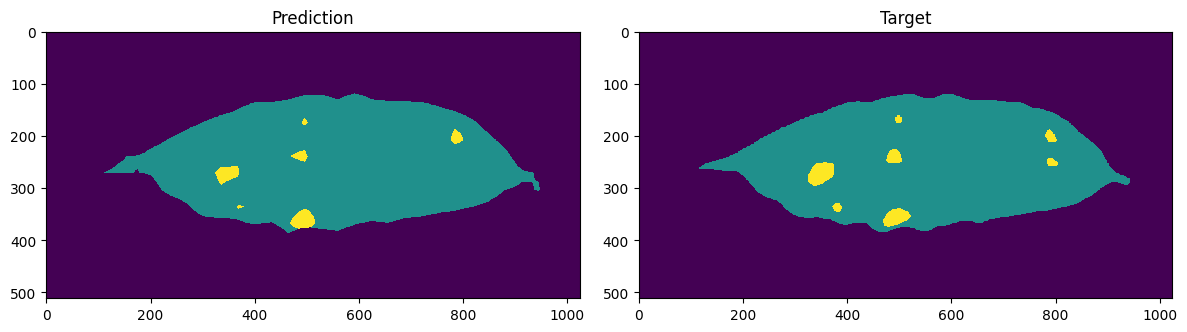

In [ ]:
i = 9

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(preds[i][0], cmap='viridis', interpolation='nearest')
axs[0].set_title("Prediction")

axs[1].imshow(targets[i][0], cmap='viridis', interpolation='nearest')
axs[1].set_title("Target")

plt.tight_layout()

plt.show()